# More `pypsa` features: more complex dispatch problems

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa matplotlib cartopy highspy
```
:::

:::{note}
These optimisation problems are adapted from the [Data Science for Energy System Modelling](https://fneum.github.io/data-science-for-esm/intro.html#) course developed by Fabian Neumann at TU Berlin.
:::

## (Repeting) basic components

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |

## Let's consider a more general form of an electricity dispatch problem


For an *hourly* electricity market dispatch simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_{i,s,t} o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{nodal energy balance : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.


:::{note}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

## South Africa & Mozambique system example

Compared to the previous example, we will consider a more complex system with more components (generators, transmission lines) and more buses. We also discuss basics of the plotting functionality built into PyPSA.

- fuel costs in € / MWh$_{th}$

In [8]:
fuel_cost = dict(
    coal=8,
    gas=100,
    oil=48,
)

- efficiencies of thermal power plants in MWh$_{el}$ / MWh$_{th}$

In [9]:
efficiency = dict(
    coal=0.33,
    gas=0.58,
    oil=0.35,
)

- specific emissions in t$_{CO_2}$ / MWh$_{th}$

In [10]:
# t/MWh thermal
emissions = dict(
    coal=0.34,
    gas=0.2,
    oil=0.26,
    hydro=0,
    wind=0,
)

- power plant capacities in MW

In [11]:
power_plants = {
    "SA": {"coal": 35000, "wind": 3000, "gas": 8000, "oil": 2000},
    "MZ": {"hydro": 1200},
}

- electrical load in MW

In [12]:
# More load to South Africa, so that it will need to import from Mozambique
loads = {
    "SA": 42000,
    "MZ": 650,
}

## Building a basic network

By convention, PyPSA is imported without an alias:

In [13]:
import pypsa

First, we create a new network object which serves as the overall container for all components.

In [15]:
n = pypsa.Network()

In [16]:
n.add("Bus", "SA", y=-30.5, x=25, v_nom=380, carrier="AC")
n.add("Bus", "MZ", y=-18.5, x=35.5, v_nom=380, carrier="AC")

In [17]:
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
name,,,,,,,,,,,,,
SA,380.0,,25.0,-30.5,AC,,,1.0,0.0,inf,PQ,,
MZ,380.0,,35.5,-18.5,AC,,,1.0,0.0,inf,PQ,,


You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components. 

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

In [18]:
n.add(
    "Carrier",
    ["coal", "gas", "oil", "hydro", "wind"],
    co2_emissions=emissions,
    nice_name=["Coal", "Gas", "Oil", "Hydro", "Onshore Wind"],
    color=["grey", "indianred", "black", "aquamarine", "dodgerblue"],
)

n.add("Carrier", ["electricity", "AC"])

In [19]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
name,,,,,
coal,0.34,grey,Coal,inf,0.0
gas,0.20,indianred,Gas,inf,0.0
oil,0.26,black,Oil,inf,0.0
hydro,0.00,aquamarine,Hydro,inf,0.0
wind,0.00,dodgerblue,Onshore Wind,inf,0.0
electricity,0.00,,,inf,0.0
AC,0.00,,,inf,0.0


Let's add a generator in Mozambique:

In [20]:
n.add(
    "Generator",
    "MZ hydro",
    bus="MZ",
    carrier="hydro",
    p_nom=1200,  # MW
    marginal_cost=0,  # default
)

In [21]:
# check that the generator was added
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
MZ hydro,MZ,PQ,,1200.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [22]:
power_plants["SA"].items()

dict_items([('coal', 35000), ('wind', 3000), ('gas', 8000), ('oil', 2000)])

Add generators in South Africa (in a loop):

In [23]:
for tech, p_nom in power_plants["SA"].items():
    n.add(
        "Generator",
        f"SA {tech}",
        bus="SA",
        carrier=tech,
        efficiency=efficiency.get(tech, 1),
        p_nom=p_nom,
        marginal_cost=fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
    )

The complete `n.generators` DataFrame looks like this now:

In [24]:
n.generators.T

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
bus,MZ,SA,SA,SA,SA
control,PQ,PQ,PQ,PQ,PQ
type,,,,,
p_nom,1200.0,35000.0,3000.0,8000.0,2000.0
p_nom_mod,0.0,0.0,0.0,0.0,0.0
p_nom_extendable,False,False,False,False,False
p_nom_min,0.0,0.0,0.0,0.0,0.0
p_nom_max,inf,inf,inf,inf,inf
p_nom_set,NaN,NaN,NaN,NaN,NaN
p_min_pu,0.0,0.0,0.0,0.0,0.0


Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [25]:
n.add(
    "Load",
    "SA electricity demand",
    bus="SA",
    p_set=loads["SA"],
    carrier="electricity",
)

n.add(
    "Load",
    "MZ electricity demand",
    bus="MZ",
    p_set=loads["MZ"],
    carrier="electricity",
)

In [26]:
n.loads

,bus,carrier,type,p_set,q_set,sign,active
name,,,,,,,
SA electricity demand,SA,electricity,,42000.0,0.0,-1.0,True
MZ electricity demand,MZ,electricity,,650.0,0.0,-1.0,True


Finally, we add the connection between Mozambique and South Africa with a 500 MW line:

In [27]:
n.add(
    "Line",
    "SA-MZ",
    bus0="SA",
    bus1="MZ",
    s_nom=500,
    x=1,
    r=1,
)

In [28]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,1.0,0.0,0.0,500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Optimisation

With all input data transferred into PyPSA's data structure, we can now build and run the resulting optimisation problem. We can have a look at the optimisation problem that will be solved by PyPSA with the `n.optimize.create_model()` function. This function returns a `linopy` model object:

In [29]:
n.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, name)
 * Line-s (snapshot, name)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, name)
 * Generator-fix-p-upper (snapshot, name)
 * Line-fix-s-lower (snapshot, name)
 * Line-fix-s-upper (snapshot, name)
 * Bus-nodal_balance (name, snapshot)

Status:
-------
initialized

In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost. The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver. We already know some solvers from the introduction to `linopy` (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [30]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.38e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-wwlljdda has 14 rows; 6 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+01, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [5e+02, 4e+04]
Presolving model
1 rows, 2 cols, 2 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-14); columns 0(-6); nonzeros 0(-19) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-wwlljdda
Model status        : Optimal
Objective value     :  1.3813912524e+06
P-D objective error :  2.5282181167e-16
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/sk/4s0w0fvj7md25wtly54j40sw0000gn/T/linopy-solve-c9y0s8qa.sol


('ok', 'optimal')

Let's have a look at the results.

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different location than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [31]:
n.generators_t.p

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,1150.0,35000.0,3000.0,1500.0,2000.0


or if you prefer it in relation to the generators nominal capacity

In [32]:
n.generators_t.p / n.generators.p_nom

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.958333,1.0,1.0,0.1875,1.0


You see that the time index has the value 'now'. This is the default index when no time series data has been specified and the network only covers a single state (e.g. a particular hour). 

Similarly you will find the power flow in transmission lines at

In [33]:
n.lines_t.p0

name,SA-MZ
snapshot,
now,-500.0


In [34]:
n.lines_t.p1

name,SA-MZ
snapshot,
now,500.0


The `p0` will tell you the flow from `bus0` to `bus1`. `p1` will tell you the flow from `bus1` to `bus0`.

What about the shadow prices?

In [35]:
n.buses_t.marginal_price

name,SA,MZ
snapshot,,
now,172.413793,-0.0


## Basic network plotting

For plotting PyPSA network, we're going to need the help of some friends:

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

PyPSA has a built-in plotting function based on `matplotlib`, ....

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x3420b28d0>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x3420b1e20>},
 'flows': {}}

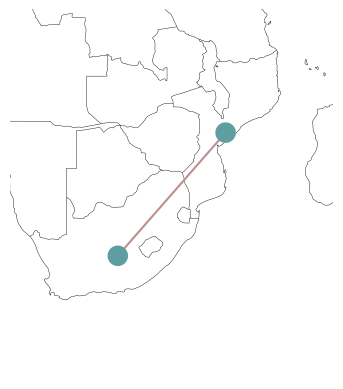

In [37]:
n.plot(margin=1, bus_sizes=1)

Since we have provided `x` and `y` coordinates for our buses, `n.plot()` will try to plot the network on a map by default. Of course, there's an option to deactivate this behaviour:

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x3441b1e50>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x34411ac60>},
 'flows': {}}

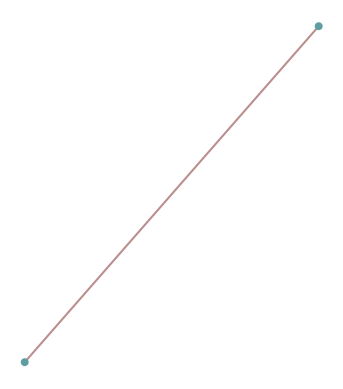

In [38]:
n.plot(geomap=False)

The `n.plot()` function has a variety of styling arguments to tweak the appearance of the buses, the lines and the map in the background:

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x3440e7b60>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x3440e64e0>},
 'flows': {}}

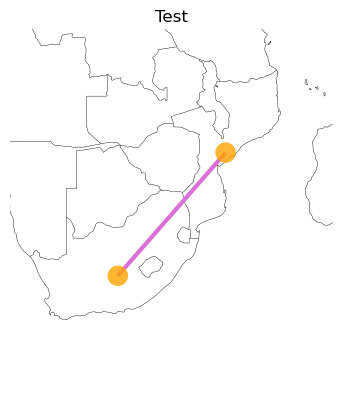

In [39]:
n.plot(
    margin=1,
    bus_sizes=1,
    bus_colors="orange",
    bus_alpha=0.8,
    line_colors="orchid",
    line_widths=3,
    title="Test",
)

We can use the `bus_sizes` argument of `n.plot()` to display the regional distribution of load. First, we calculate the total load per bus:

In [40]:
s = n.loads.groupby("bus").p_set.sum() / 1e4
s

bus
MZ    0.065
SA    4.200
Name: p_set, dtype: float64

The resulting `pandas.Series` we can pass to `n.plot(bus_sizes=...)`:

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x3440f8200>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x34417f2f0>},
 'flows': {}}

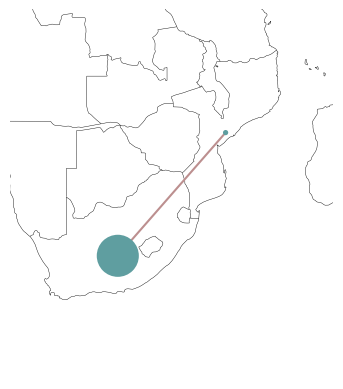

In [41]:
n.plot(margin=1, bus_sizes=s)

The important point here is, that `s` needs to have entries for all buses, i.e. its index needs to match `n.buses.index`.

The `bus_sizes` argument of `n.plot()` can be even more powerful. It can produce pie charts, e.g. for the mix of electricity generation at each bus.

The dispatch of each generator, we can find at:

In [42]:
n.generators_t.p.loc["now"]

name
MZ hydro     1150.0
SA coal     35000.0
SA wind      3000.0
SA gas       1500.0
SA oil       2000.0
Name: now, dtype: float64

If we group this by the **bus** and **carrier**...

In [43]:
n.generators.carrier

name
MZ hydro    hydro
SA coal      coal
SA wind      wind
SA gas        gas
SA oil        oil
Name: carrier, dtype: object

... we get a multi-indexed `pandas.Series` ...

In [44]:
s = n.generators_t.p.loc["now"].groupby([n.generators.bus, n.generators.carrier]).sum()
s

bus  carrier
MZ   hydro       1150.0
SA   coal       35000.0
     gas         1500.0
     oil         2000.0
     wind        3000.0
Name: now, dtype: float64

... which we can pass to `n.plot(bus_sizes=...)`:

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x34417c530>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x344149a00>},
 'flows': {}}

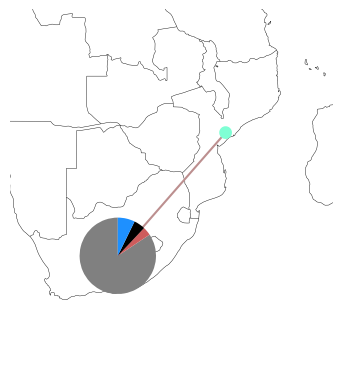

In [45]:
n.plot(margin=1, bus_sizes=s / 3000)

**How does this magic work?** The plotting function will look up the colors specified in `n.carriers` for each carrier and match it with the second index-level of `s`.

## Modifying networks

Modifying data of components in an existing PyPSA network is as easy as modifying the entries of a `pandas.DataFrame`. For instance, if we want to reduce the cross-border transmission capacity between South Africa and Mozambique, we'd run:

In [46]:
n.lines.loc["SA-MZ", "s_nom"] = 100

In [47]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
name,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,1.0,0.0,0.0,100.0,0.0,False,...,inf,0,0.000007,0.000007,0.0,0.0,0.000007,0.000007,500.0,380.0


In [48]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.45e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-4orwuzlu has 14 rows; 6 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+01, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [1e+02, 4e+04]
Presolving model
1 rows, 2 cols, 2 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-14); columns 0(-6); nonzeros 0(-19) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-4orwuzlu
Model status        : Optimal
Objective value     :  1.4503567697e+06
P-D objective error :  4.0133325858e-16
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/sk/4s0w0fvj7md25wtly54j40sw0000gn/T/linopy-solve-ioi878h9.sol


('ok', 'optimal')

You can see that the production of the hydro power plant was reduced and that of the gas power plant increased owing to the reduced transmission capacity.

In [49]:
n.generators_t.p

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,750.0,35000.0,3000.0,1900.0,2000.0


## Add a global constraint for emission limits

In the example above, we happen to have some spare gas capacity with lower carbon intensity than the coal and oil generators. We could use this to lower the emissions of the system, but it will be more expensive. We can implement the limit of carbon dioxide emissions as a constraint.

This is achieved in PyPSA through **Global Constraints** which add constraints that apply to many components at once.

But first, we need to calculate the current level of emissions to set a sensible limit.

We can compute the emissions per generator (in tonnes of CO$_2$) in the following way.

$$\frac{g_{i,s,t} \cdot \rho_{i,s}}{\eta_{i,s}}$$

where $ \rho$ is the specific emissions (tonnes/MWh thermal) and $\eta$ is the conversion efficiency (MWh electric / MWh thermal) of the generator with dispatch $g$ (MWh electric):

In [50]:
e = (
    n.generators_t.p # power output time series (netto)
    / n.generators.efficiency # get brutto power output
    * n.generators.carrier.map(n.carriers.co2_emissions) # emissions factor (emissions per produced energy unit - brutto)
)
e # emissions time series

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.0,36060.606061,0.0,655.172414,1485.714286


Summed up, we get total emissions in tonnes:

In [51]:
# total emissions: all generators, over full time period (here, single time step) 
e.sum().sum()

38201.49276011344

In [52]:
n.model

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, name)
 * Line-s (snapshot, name)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, name)
 * Generator-fix-p-upper (snapshot, name)
 * Line-fix-s-lower (snapshot, name)
 * Line-fix-s-upper (snapshot, name)
 * Bus-nodal_balance (name, snapshot)

Status:
-------
ok

So, let's say we want to reduce emissions by 10%:

In [53]:
n.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=e.sum().sum() * 0.9, # limit to 90% of previous emissions
)

In [54]:
n.optimize.create_model()

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, name)
 * Line-s (snapshot, name)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, name)
 * Generator-fix-p-upper (snapshot, name)
 * Line-fix-s-lower (snapshot, name)
 * Line-fix-s-upper (snapshot, name)
 * Bus-nodal_balance (name, snapshot)
 * GlobalConstraint-emission_limit

Status:
-------
initialized

In [55]:
# let's check the new global constraint
n.model.constraints["GlobalConstraint-emission_limit"]

Constraint `GlobalConstraint-emission_limit`
--------------------------------------------
+1.03 Generator-p[now, SA coal] + 0.3448 Generator-p[now, SA gas] + 0.7429 Generator-p[now, SA oil] ≤ 34381.3434841021

In [56]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 15 duals
Objective: 2.21e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-hv775ecs has 15 rows; 6 cols; 22 nonzeros
Coefficient ranges:
  Matrix  [3e-01, 1e+00]
  Cost    [2e+01, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [1e+02, 4e+04]
Presolving model
2 rows, 3 cols, 6 nonzeros  0s
1 rows, 2 cols, 2 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-15); columns 0(-6); nonzeros 0(-22) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-hv775ecs
Model status        : Optimal
Objective value     :  2.2123131990e+06
P-D objective error :  2.1048610218e-16
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/sk/4s0w0fvj7md25wtly54j40sw0000gn/T/linopy-solve-mzh1ef8o.sol


('ok', 'optimal')

In [57]:
# Results in way more wind and hydro, marginal oil
n.generators_t.p

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,750.0,30156.761529,3000.0,8000.0,743.238471


In [58]:
n.generators_t.p / n.generators.p_nom

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.625,0.861622,1.0,1.0,0.371619


In [59]:
n.global_constraints.mu

name
emission_limit   -392.771084
Name: mu, dtype: float64

Can we lower emissions even further? Say by another 5% points?

In [60]:
n.global_constraints.loc["emission_limit", "constant"] = 0.85

In [61]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible



Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-01mpnqtw has 15 rows; 6 cols; 22 nonzeros
Coefficient ranges:
  Matrix  [3e-01, 1e+00]
  Cost    [2e+01, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [8e-01, 4e+04]
Presolving model
Problem status detected on presolve: Infeasible
Model name          : linopy-problem-01mpnqtw
Model status        : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/sk/4s0w0fvj7md25wtly54j40sw0000gn/T/linopy-solve-97co4jux.sol


('warning', 'infeasible')

No! Without any additional capacities, we have exhausted our options to reduce CO2 in that hour. The optimiser tells us that the problem is *infeasible*.

## A slightly more realistic example

**Dispatch problem with German SciGRID network**


[SciGRID](https://www.scigrid.de/pages/general-information.html) is a project that provides an open reference model of the European transmission network. The network comprises time series for loads and the availability of renewable generation at an hourly resolution for January 1, 2011 as well as approximate generation capacities in 2014. This dataset is a little out of date and only intended to demonstrate the capabilities of PyPSA.

In [62]:
n = pypsa.examples.scigrid_de()

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v1.0.3/examples/networks/scigrid-de/scigrid-de.nc.
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x3467d1a60>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x346d32630>,
  'Transformer': <matplotlib.collections.LineCollection at 0x3440f8f50>},
 'flows': {}}

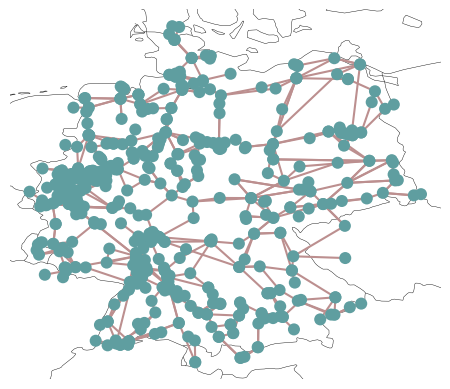

In [63]:
n.plot()

There are some infeasibilities without allowing extension. Moreover, to approximate so-called $N-1$ security, we don't allow any line to be loaded above 70% of their thermal rating. $N-1$ security is a constraint that states that no single transmission line may be overloaded by the failure of another transmission line (e.g. through a tripped connection).

In [64]:
n.lines.s_max_pu = 0.7
n.lines.loc[["316", "527", "602"], "s_nom"] = 1715

Because this network includes time-varying data, now is the time to look at another attribute of `n`: `n.snapshots`. Snapshots is the PyPSA terminology for time steps. In most cases, they represent a particular hour. They can be a `pandas.DatetimeIndex` or any other list-like attributes.

In [65]:
n.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

This index will match with any time-varying attributes of components:

In [66]:
n.loads_t.p_set.head()

name,1,3,4,6,7,8,9,11,14,16,...,382_220kV,384_220kV,385_220kV,391_220kV,403_220kV,404_220kV,413_220kV,421_220kV,450_220kV,458_220kV
snapshot,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,231.716206,40.613618,66.790442,196.124424,147.804142,123.671946,83.637404,73.280624,175.260369,298.900165,...,202.010114,222.695091,212.621816,77.570241,16.148970,0.092794,58.427056,67.013686,38.449243,66.752618
2011-01-01 01:00:00,221.822547,38.879526,63.938670,187.750439,141.493303,118.391487,80.066312,70.151738,167.777223,286.137932,...,193.384825,213.186609,203.543436,74.258201,15.459452,0.088831,55.932378,64.152382,36.807564,63.902460
2011-01-01 02:00:00,213.127360,37.355494,61.432348,180.390839,135.946929,113.750678,76.927805,67.401871,161.200550,274.921657,...,185.804364,204.829941,195.564769,71.347365,14.853460,0.085349,53.739893,61.637683,35.364750,61.397558
2011-01-01 03:00:00,207.997501,36.456367,59.953705,176.048930,132.674761,111.012761,75.076195,65.779545,157.320541,268.304442,...,181.332154,199.899796,190.857632,69.630073,14.495945,0.083295,52.446403,60.154097,34.513540,59.919752
2011-01-01 04:00:00,200.194899,35.088781,57.704664,169.444814,127.697738,106.848344,72.259865,63.311960,151.418982,258.239549,...,174.529848,192.400963,183.697997,67.018043,13.952159,0.080170,50.478984,57.897539,33.218835,57.671985
2011-01-01 05:00:00,185.808225,32.567184,53.557814,157.267944,118.520953,99.169865,67.067030,58.762151,140.537508,239.681593,...,161.987551,178.574388,170.496846,62.201903,12.949511,0.074409,46.851395,53.736829,30.831619,53.527484
2011-01-01 06:00:00,185.913530,32.585641,53.588168,157.357074,118.588123,99.226069,67.105039,58.795454,140.617157,239.817430,...,162.079356,178.675593,170.593474,62.237155,12.956850,0.074451,46.877948,53.767284,30.849092,53.557820
2011-01-01 07:00:00,189.017522,33.129687,54.482870,159.984290,120.568057,100.882736,68.225418,59.777096,142.964885,243.821395,...,164.785415,181.658741,173.441683,63.276260,13.173176,0.075694,47.660617,54.664976,31.364145,54.452015
2011-01-01 08:00:00,200.711395,35.179309,57.853540,169.881976,128.027194,107.124009,72.446293,63.475302,151.809638,258.905798,...,174.980129,192.897351,184.171932,67.190947,13.988155,0.080377,50.609218,58.046913,33.304538,57.820777


<Axes: xlabel='snapshot', ylabel='MW'>

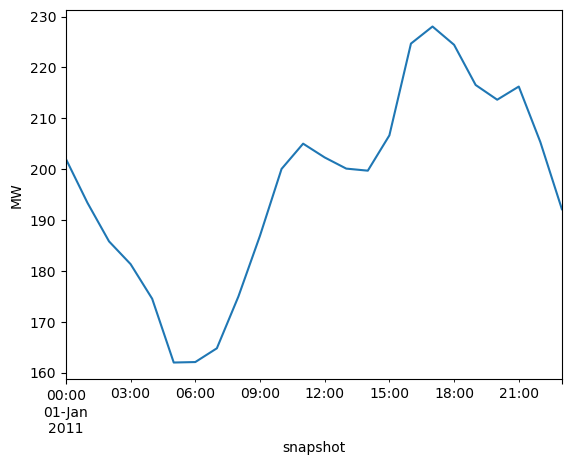

In [68]:
n.loads_t.p_set["382_220kV"].plot(ylabel="MW")

Let's inspect capacity factor time series for renewable generators:

<Axes: xlabel='snapshot', ylabel='p.u.'>

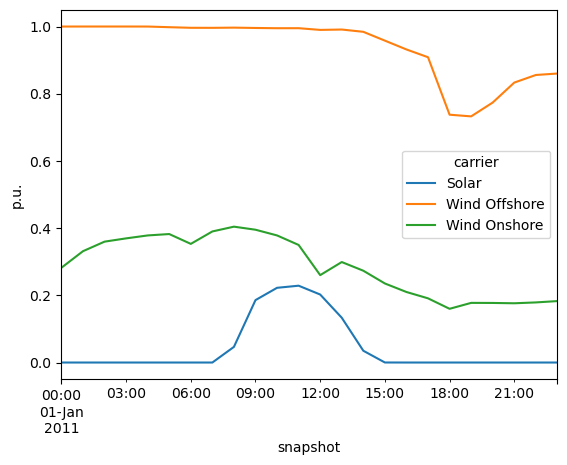

In [69]:
# Daily periodicity for solar; rather random wind
n.generators_t.p_max_pu.T.groupby(n.generators.carrier).mean().T.plot(ylabel="p.u.")

We can also inspect the total power plant capacities per technology...

In [70]:
n.generators.carrier.unique()

array(['Gas', 'Hard Coal', 'Run of River', 'Waste', 'Brown Coal', 'Oil',
       'Storage Hydro', 'Other', 'Multiple', 'Nuclear', 'Geothermal',
       'Wind Offshore', 'Wind Onshore', 'Solar'], dtype=object)

Text(0.5, 0, 'GW')

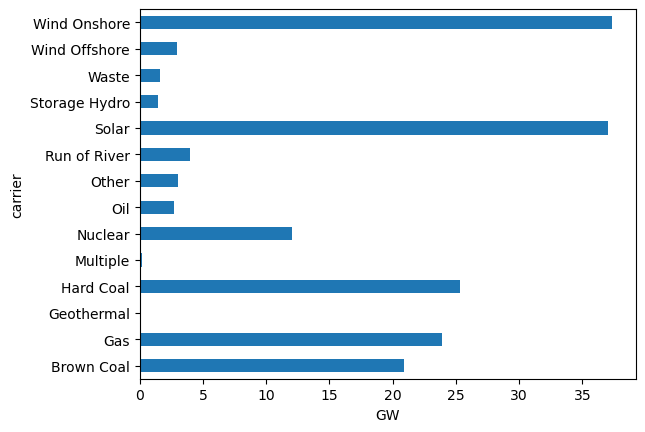

In [71]:
n.generators.groupby("carrier").p_nom.sum().div(1e3).plot.barh()
plt.xlabel("GW")

... and plot the regional distribution of loads...

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x347edc350>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x3440facc0>,
  'Transformer': <matplotlib.collections.LineCollection at 0x347fcb620>},
 'flows': {}}

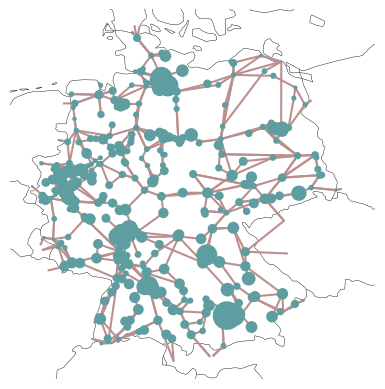

In [72]:
# Aggregate spatially by demand center (aka, load bus)
load = n.loads_t.p_set.sum(axis=0).groupby(n.loads.bus).sum()
fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
n.plot(
    ax=ax,
    bus_sizes=load / 2e5,
)

... and power plant capacities:

In [73]:
capacities = n.generators.groupby(["bus", "carrier"]).p_nom.sum()

For plotting we need to assign some colors to the technologies.

In [74]:
import random

carriers = list(n.generators.carrier.unique()) + list(n.storage_units.carrier.unique())
colors = ["#%06x" % random.randint(0, 0xFFFFFF) for _ in carriers]
n.add("Carrier", carriers, color=colors, overwrite=True)

Because we want to see which color represents which technology, we cann add a legend using the  `add_legend_patches` function of PyPSA.

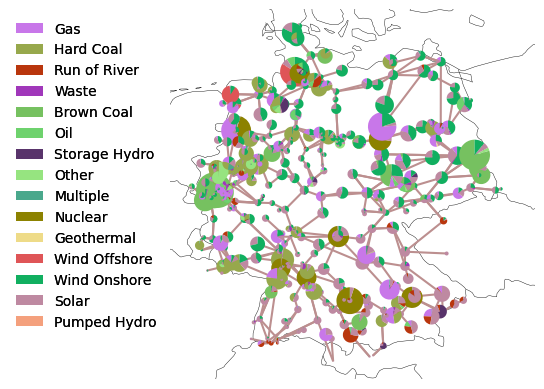

In [75]:
from pypsa.plot import add_legend_patches

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=capacities / 2e4,
)
add_legend_patches(
    ax, colors, carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
)

This dataset also includes a few hydro storage units:

In [76]:
n.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
100_220kV Pumped Hydro,100_220kV,PQ,,144.5,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0
114 Pumped Hydro,114,PQ,,138.0,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0
121 Pumped Hydro,121,PQ,,238.0,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0


So let's solve the electricity market simulation for January 1, 2011. It'll take a short moment.

In [77]:
n.optimize(solver_name="highs")

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 117.94it/s]
INFO:linopy.io: Writing time: 0.44s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-yjzitdfr has 142968 rows; 59640 cols; 261298 nonzeros
Coefficient ranges:
  Matrix  [1e-02, 2e+02]
  Cost    [3e+00, 1e+02]
  Bound   [0e+00, 0e+00]
  RHS     [2e-11, 6e+03]
Presolving model
18737 rows, 44750 cols, 113266 nonzeros  0s
13253 rows, 39072 cols, 104687 nonzeros  0s
12725 rows, 31714 cols, 97262 nonzeros  0s
Dependent equations search running on 12697 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
12697 rows, 31673 cols, 97185 nonzeros  0s
Presolve reductions: rows 12697(-130271); columns 31673(-27967); nonzeros 97185(-164113) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      17275     9.1992880405e+06 Pr: 0(0); Du: 0(3.16005e-13) 2s
      17275     9.1992880405e+06 Pr: 0(0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 59640 primals, 142968 duals
Objective: 9.20e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, we can also plot model outputs. Let's plot the hourly dispatch grouped by carrier:

In [78]:
supply_by_carrier = (
    n.statistics.supply(
        components=["Generator", "StorageUnit"], groupby="carrier", groupby_time=False
    )
    .div(1e3)  # MW -> GW
    .fillna(0)
)

df = supply_by_carrier.T
fig, ax = plt.subplots(figsize=(14.5, 5))
df.plot(kind="area", ax=ax, linewidth=0, cmap="tab20b")
ax.legend(ncol=5, loc="upper left", frameon=False)
ax.set_ylabel("GW")
ax.set_ylim(0, df.sum(axis=1).max() * 1.2)
fig.tight_layout()

name
1      0.7
2      0.7
3      0.7
4      0.7
5      0.7
      ... 
855    0.7
856    0.7
857    0.7
858    0.7
859    0.7
Name: s_max_pu, Length: 852, dtype: float64

Or the calculated power flows on the network map:

In [ ]:
# How much is each line used compared to its capacity (aka, utilization)?
line_loading = n.lines_t.p0.iloc[0].abs() / n.lines.s_nom / n.lines.s_max_pu * 100  # %

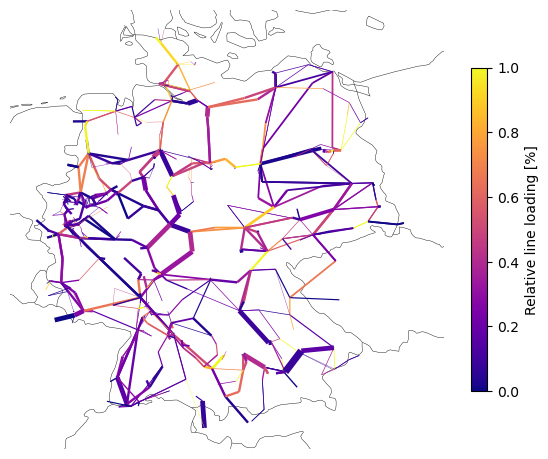

In [80]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_cmap="plasma",
    line_widths=n.lines.s_nom / 1000,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma"),
    ax=ax,
    label="Relative line loading [%]",
    shrink=0.6,
)

Or plot the locational marginal prices (LMPs):

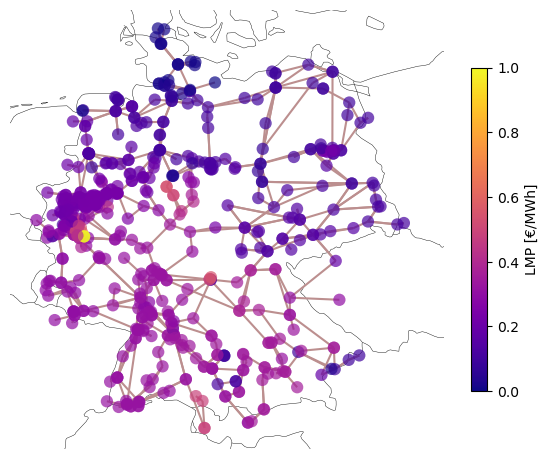

In [ ]:
# Energy grid price per location
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_colors=n.buses_t.marginal_price.mean(),
    bus_cmap="plasma",
    bus_alpha=0.7,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma"),
    ax=ax,
    label="LMP [€/MWh]",
    shrink=0.6,
)

## Data import and export

:::{note}
Documentation: https://pypsa.readthedocs.io/en/latest/import_export.html.
:::

You may find yourself in a need to store PyPSA networks for later use. Or, maybe you want to import the genius PyPSA example that someone else uploaded to the web to explore.

PyPSA can be stored as `netCDF` (`.nc`) file or as a folder of `CSV` files.

* `netCDF` files have the advantage that they take up less space than `CSV` files and are faster to load.
* `CSV` might be easier to use with `Excel`.

In [77]:
n.export_to_csv_folder("tmp")

INFO:pypsa.network.io:Exported network 'SciGrid-DE' saved to 'tmp contains: sub_networks, generators, transformers, loads, storage_units, lines, carriers, buses


In [78]:
n.export_to_netcdf("tmp.nc")

INFO:pypsa.network.io:Exported network 'SciGrid-DE' saved to 'tmp.nc contains: sub_networks, generators, transformers, loads, storage_units, lines, carriers, buses


<xarray.Dataset> Size: 2MB
Dimensions:                            (snapshots: 24, sub_networks_i: 1,
                                        generators_i: 1423,
                                        generators_t_p_max_pu_i: 982,
                                        generators_t_p_i: 1196,
                                        transformers_i: 96,
                                        transformers_t_p0_i: 96,
                                        ...
                                        storage_units_t_state_of_charge_i: 38,
                                        lines_i: 852, lines_t_p0_i: 852,
                                        lines_t_p1_i: 852, carriers_i: 16,
                                        buses_i: 585, buses_t_p_i: 489,
                                        buses_t_v_ang_i: 585,
                                        buses_t_marginal_price_i: 584)
Coordinates: (12/24)
  * snapshots                          (snapshots) int64 192B 0 1 2 ... 21 22 23
  * sub_networks_i                     (sub_networks_i) object 8B '0'
  * generators_i                       (generators_i) object 11kB '1 Gas' ......
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object 8kB '...
  * generators_t_p_i                   (generators_t_p_i) object 10kB '1 Hard...
  * transformers_i                     (transformers_i) object 768B '2' ... '...
    ...                                 ...
  * lines_t_p1_i                       (lines_t_p1_i) object 7kB '1' ... '859'
  * carriers_i                         (carriers_i) object 128B 'AC' ... 'Pum...
  * buses_i                            (buses_i) object 5kB '1' ... '458_220kV'
  * buses_t_p_i                        (buses_t_p_i) object 4kB '1' ... '458_...
  * buses_t_v_ang_i                    (buses_t_v_ang_i) object 5kB '1' ... '...
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 5kB ...
Data variables: (12/90)
    snapshots_snapshot                 (snapshots) datetime64[ns] 192B 2011-0...
    snapshots_objective                (snapshots) float64 192B 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 192B 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 192B 1.0 1.0 ... 1.0
    sub_networks_slack_bus             (sub_networks_i) object 8B '1'
    sub_networks_obj                   (sub_networks_i) float64 8B nan
    ...                                 ...
    buses_osm_name                     (buses_i) object 5kB 'Hannover/West' ....
    buses_operator                     (buses_i) object 5kB 'TenneT;EON_Netz'...
    buses_frequency                    (buses_i) object 5kB '50' '50' ... '50'
    buses_t_p                          (snapshots, buses_t_p_i) float64 94kB ...
    buses_t_v_ang                      (snapshots, buses_t_v_ang_i) float64 112kB ...
    buses_t_marginal_price             (snapshots, buses_t_marginal_price_i) float64 112kB ...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           9199288.04053988
    network__objective_constant:  0.0
    network_name:                 SciGrid-DE
    network_now:                  now
    network_pypsa_version:        1.0.3
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}

In [79]:
n_nc = pypsa.Network("tmp.nc")

INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, sub_networks, transformers


In [80]:
n_nc

PyPSA Network 'SciGrid-DE'
--------------------------
Components:
 - Bus: 585
 - Carrier: 16
 - Generator: 1423
 - Line: 852
 - Load: 489
 - StorageUnit: 38
 - SubNetwork: 1
 - Transformer: 96
Snapshots: 24